In [ ]:
# Install fastai
!pip install fastai -q
!pip install fastai --upgrade

In [2]:
from fastai.tabular.all import *
import pandas as pd
import csv

Add the 'level1.csv' and 'test_level1.csv' files into the current directory. You can do this by clicking the folder icon on the left hand side and drag the csvs into the empty space.

In [7]:
# Load the csv as a dataframe
path = Path(".")
df1 = pd.read_csv(path/'level1.csv')
# Remove the id column from R's dataframe
del df1['Unnamed: 0']

In [8]:
# Check the first categorical variable before duration
list(df1.columns)[6]

'confirmed'

In [9]:
# Check duration
list(df1.columns)[7]

'duration'

In [10]:
list(df1.columns)[12]

'respiratory symptoms'

In [11]:
# Get a list of categorical columns
df1_cat = list(df1.columns)

df1_cat = df1_cat[1:6] + df1_cat[9: ]
# Only age and duration are numerical, the others are categorical

In [12]:
# Convert confirmed date into datetime
df1['confirmed'] = pd.to_datetime(df1['confirmed'])
df1['confirmed'] = (df1['confirmed'] - pd.to_datetime('1970-01-01')).dt.total_seconds()

In [13]:
# Get a list of numerical columns, not counting the thing we're predicting
df1_num = list(df1.columns)
df1_num = df1_num[6:7] + df1_num[8:9]
# The only numerical columns are the age and duration
# We don't include duration because we are predicting it
list(df1.columns)[8]
# This column should be about age

'clean_age'

In [ ]:
# Uncomment below to check types of the columns
###df1.dtypes

In [ ]:
# I determined the y_range by using
# ```max(merged_df1$duration)```
# in R and adding one to the maximum. I remember it being recommended
# by the fast.ai prof, I think because the neuron is asymptotic to
# the maximum value, I'm not entirely sure.

In [14]:
# Training and validation splits
splits = RandomSplitter(valid_pct=0.2)(range_of(df1))

In [15]:
# This is some a data cleaning step
to = TabularPandas(df1, procs = [Categorify, FillMissing, Normalize],
                   cat_names = df1_cat, cont_names = df1_num,
                   y_names = 'duration',
                   splits = splits)
# This determines batch size
dls = to.dataloaders(bs = 4)

In [16]:
# y_range is used so that the model knows it's doing regression
# I chose 33 because the max of the training duration is 32
# We are using 2 hidden layers, 50 neurons in the first, 25 in the second
learn = tabular_learner(dls, y_range = (0, 33), metrics = rmse,
                        layers = [50, 25])

SuggestedLRs(lr_min=0.33113112449646, lr_steep=9.12010818865383e-07)

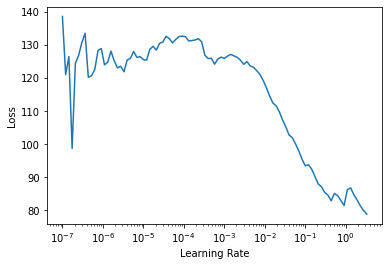

In [17]:
# Use this to figure out what learning rate to use
learn.recorder.lr_find()

In [18]:
learn.fit_one_cycle(10, lr_max = 0.33, wd=0.8)

epoch,train_loss,valid_loss,_rmse,time
0,38.665936,51.996895,7.210887,00:00
1,30.488955,14.475944,3.804726,00:00
2,29.485437,14.556060,3.815240,00:00
3,27.408520,14.701720,3.834282,00:00
4,26.895691,15.432599,3.928435,00:00
5,27.436529,14.351961,3.788399,00:00
6,26.080399,14.335310,3.786200,00:00
7,24.725805,14.350292,3.788178,00:00
8,24.827246,14.479972,3.805256,00:00
9,25.183435,14.416428,3.796897,00:00


In [19]:
# Load the test set
df2 = pd.read_csv(path/'test_level1.csv')

In [20]:
# Look at the first column
list(df2.columns)[0]

'Unnamed: 0'

In [21]:
# Remove the id column from R's dataframe
del df2['Unnamed: 0']

In [22]:
# Convert confirmed date into datetime
df2['confirmed'] = pd.to_datetime(df2['confirmed'])
df2['confirmed'] = (df2['confirmed'] - pd.to_datetime('1970-01-01')).dt.total_seconds()

In [23]:
# Create the test set data frame
dl = learn.dls.test_dl(df2)

In [24]:
# Get the predictions from the model on the test set
p1 = learn.get_preds(dl = dl)

In [25]:
# Get the list of predictions
p2 = p1[0].tolist()

In [26]:
# Print the predictions to a csv file
with open('testing.csv', mode='w') as employee_file:
  employee_writer = csv.writer(employee_file, delimiter = ',',
                               quotechar = '"', quoting = csv.QUOTE_MINIMAL)
  employee_writer.writerow(p2)
print("Done")

Done
